In [8]:
!nvidia-smi

Tue Nov 25 17:28:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.07                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8             12W /  130W |    5562MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import os
HOME = os.getcwd()
KITTI_PATH = f"{HOME}/refer-kitti/KITTI/training/image_02/"
print(HOME)

D:\CSProject\ByteTrackLLM_HOTA


# Download Data

In [12]:
!gdown -O "0005.zip" "https://drive.google.com/uc?id=1aJx81SILqLSjLzyLUUcLntDxWl2JDSSW"

In [13]:
!unzip "/content/0005.zip"

'unzip' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


# Use Ultralytics

In [14]:
! pip install -U ultralytics
! pip install utils

In [15]:
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

D:\CSProject\ByteTrackLLM_HOTA/refer-kitti/KITTI/training/image_02/

image 1/1 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\testing\image_02\0005\000001.png: 224x640 2 cars, 17.9ms
Speed: 2.0ms preprocess, 17.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
tensor([[230.6004, 195.3319, 276.7632, 216.5249],
        [231.4475, 196.2470, 337.2482, 226.5918]], device='cuda:0')


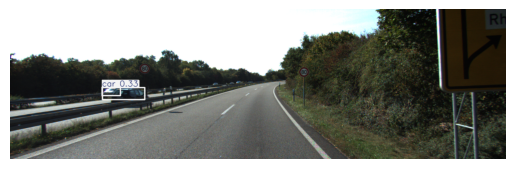

In [16]:
# Load a model
model = YOLO("yolo11n.pt")  # load an official model
# model = YOLO("path/to/best.pt")  # load a custom model
print(KITTI_PATH)
# Predict with the model
# results = model("/content/0006/000000.png")  # predict on an image
results = model(r"D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\testing\image_02\0005\000001.png")
  # predict on an image on local disk

# Access the results
for result in results:
    xywh = result.boxes.xywh  # center-x, center-y, width, height
    xywhn = result.boxes.xywhn  # normalized
    xyxy = result.boxes.xyxy  # top-left-x, top-left-y, bottom-right-x, bottom-right-y
    xyxyn = result.boxes.xyxyn  # normalized
    names = [result.names[cls.item()] for cls in result.boxes.cls.int()]  # class name of each box
    confs = result.boxes.conf  # confidence score of each box

    img = result.plot()
    plt.imshow(img[..., ::-1])
    plt.axis('off')
    print(xyxy)

In [17]:
from dataclasses import dataclass

@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8

In [18]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np
# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)

@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x

    @property
    def min_y(self) -> float:
        return self.y

    @property
    def max_x(self) -> float:
        return self.x + self.width

    @property
    def max_y(self) -> float:
        return self.y + self.height

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding,
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )

    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result

# Full video tracking

In [19]:
from typing import List
import numpy as np
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: List[Detection],
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

In [20]:
from tqdm.notebook import tqdm

In [21]:
import os
from ultralytics import YOLO

KITTI_PATH = r"D:\CSProject\ByteTrackLLM_HOTA\refer-kitti"

model = YOLO("yolo11n.pt")
seq = os.path.join(KITTI_PATH, "training", "image_02", "0005")

print("Using path:", seq)
assert os.path.exists(seq), "Path not found!"

results = model.track(source=seq, tracker="bytetrack.yaml", persist=True)


Using path: D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0005

image 1/297 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0005\000000.png: 224x640 3 cars, 18.0ms
image 2/297 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0005\000001.png: 224x640 3 cars, 17.3ms
image 3/297 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0005\000002.png: 224x640 2 cars, 17.2ms
image 4/297 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0005\000003.png: 224x640 2 cars, 17.1ms
image 5/297 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0005\000004.png: 224x640 3 cars, 13.8ms
image 6/297 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0005\000005.png: 224x640 3 cars, 13.6ms
image 7/297 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0005\000006.png: 224x640 3 cars, 13.7ms
image 8/297 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0005\000007.png: 224x640 3 cars, 13.6ms
image 9/297 D:\CS

In [22]:
if results:
    # Access the Results object for the first frame
    first_frame_results = results[0]

    # Check if there are any detected boxes in the first frame
    if first_frame_results.boxes is not None:
        print("Detections and Tracks for the First Frame:")
        for box in first_frame_results.boxes:
            # Bounding box coordinates (xyxy format)
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            print("id: ",box.id[0])

            # Class ID and Name
            class_id = int(box.cls[0].cpu().numpy())
            class_name = first_frame_results.names[class_id]

            # Confidence Score
            confidence = float(box.conf[0].cpu().numpy())

            # Tracker ID (important for tracking results)
            tracker_id = int(box.id[0].cpu().numpy()) if box.id is not None else "N/A"

            print(f"  Object ID: {tracker_id}, Class: {class_name} (ID: {class_id}), Confidence: {confidence:.2f}, BBox: [{x1}, {y1}, {x2}, {y2}]")
    else:
        print("No detections in the first frame.")
else:
    print("No results found. Ensure model.track() was executed successfully.")

Detections and Tracks for the First Frame:
id:  tensor(1.)
  Object ID: 1, Class: car (ID: 2), Confidence: 0.63, BBox: [254, 175, 302, 201]
id:  tensor(2.)
  Object ID: 2, Class: car (ID: 2), Confidence: 0.54, BBox: [569, 171, 609, 207]
id:  tensor(3.)
  Object ID: 3, Class: car (ID: 2), Confidence: 0.37, BBox: [321, 178, 351, 196]


In [23]:
import json

# helper function to crop the detected objects from the frame
def write_gt(gt_path, save_path, expression_path, labels_path, video_id, expression):
  save_format = "{frame},{id},{x1},{y1},{w},{h},1, 1, 1\n"

  with open(os.path.join(expression_path, video_id, expression+".json")) as f:
      json_info = json.load(f)

  # FIX: Get image dimensions from the first available frame
#   ORI_PATH = f"{HOME}/refer-kitti/training/image_02/{video_id}"
  ORI_PATH = os.path.join(HOME, "refer-kitti", "training", "image_02", video_id)
  # "D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0000"
  first_frame_id = int(list(json_info["label"].keys())[0])
  img_path = os.path.join(ORI_PATH, f"{first_frame_id:06d}.png")
  img = cv2.imread(img_path)
  seq_h, seq_w, _ = img.shape

  labels_path = os.path.join(labels_path, video_id)
  if(not os.path.exists(os.path.join(save_path,video_id,expression)) ):
    os.mkdir(os.path.join(save_path,video_id,expression))
#   print(f"json_info:{json_info}")
  with open(os.path.join(save_path, video_id, expression, "gt.txt"), "w") as f:
      for k in json_info["label"].keys():
          frame_id = int(k)
          if not os.path.isfile(
              os.path.join(labels_path, "{:06d}.txt".format(frame_id))
          ):
              continue
          frame_gt = np.loadtxt(
              os.path.join(labels_path, "{:06d}.txt".format(frame_id))
          ).reshape(-1, 6)
          for frame_gt_line in frame_gt:
              aa = json_info["label"][k]  # all gt from frame
              aa = [int(a) for a in aa]
              if int(frame_gt_line[1]) in aa:  # choose referent gt from all gt
                  track_id = int(frame_gt_line[1])
                  x1, y1, w, h = frame_gt_line[2:6]  # KITTI -> [x1, y1, w, h]
                  line = save_format.format(
                      frame=frame_id + 1,
                      id=track_id,
                      x1=x1 * seq_w,
                      y1=y1 * seq_h,
                      w=w * seq_w,
                      h=h * seq_h,
                  )
                  f.write(line)

#   print("save gt to {}".format(os.path.join(save_path, video_id, expression, "gt.txt")))
        

In [24]:

def save_crops_from_detections(box, frame_id, crops_dir):
  """Save cropped images of detected objects for LLM analysis."""
  # ORI_PATH = f"{HOME}/refer-kitti/KITTI/training/image_02/0005"
  ORI_PATH = os.path.join(HOME, "refer-kitti", "training", "image_02", video_id)
  img_path = os.path.join(ORI_PATH, f"{frame_id-1:06d}.png")
  img = cv2.imread(img_path)
  
  seq_h, seq_w, _ = img.shape

  os.makedirs(crops_dir, exist_ok=True)
  x1, y1, x2, y2 = list(map(int, box.xyxy[0]))
  crop = img[y1:y2, x1:x2]
  if crop.size > 0:  # Make sure crop is valid
      save_path = os.path.join(crops_dir, f"i{int(box.id[0])}_f{frame_id}.jpg")
      cv2.imwrite(save_path, crop)

In [ ]:
from dataclasses import dataclass

@dataclass
class Crop_Img:
    frame_id: int
    tracker_id: int
    bbox: dict  # {'x1': ..., 'y1': ..., 'x2': ..., 'y2': ...}
    width: int
    height: int
    crop_path: str
    cls: int = None   # ← optional: new class id

    # ---- properties ----
    @property
    def x1(self):
        return self.bbox.get('x1', 0)
    
    @property
    def y1(self):
        return self.bbox.get('y1', 0)
    
    @property
    def x2(self):
        return self.bbox.get('x2', 0)
    
    @property
    def y2(self):
        return self.bbox.get('y2', 0)

    # ---- class name mapping ----
    def get_class(self, cls_id):
        """Convert class id into readable text."""
        mapping = {
            0: "car",
            1: "pedestrian",
            2: "cyclist",
            3: "truck",
            4: "bus",
            5: "motorcycle",
            6: "bicycle",
        }
        return mapping.get(cls_id, f"class_{cls_id}")


In [ ]:
import os, json, cv2
import shutil
import sys
# add the directory of LLM.py into system path
sys.path.append(r"D:\CSProject\ByteTrackLLM_HOTA\Bytetrack-dumb-clean")
from LLM import select_targets

def inference(EXP_PATH, EXPRESSION_PATH, seq, results):
    SEQ_PATH = os.path.join(EXPRESSION_PATH, seq[0], seq[1])
    save_format = "{frame},{id},{x1},{y1},{w},{h},1,1,1\n"
    with open(SEQ_PATH, "r", encoding="utf-8") as f:
        prompt = json.load(f)
        sentence = prompt.get("sentence", "")

    expression_str = seq[1].split(".")[0]
    exp_dir = os.path.join(EXP_PATH, seq[0], expression_str)
    os.makedirs(exp_dir, exist_ok=True)
    predict_path = os.path.join(exp_dir, "predict.txt")

    os.makedirs("crops/", exist_ok=True)

    first_frame_path = os.path.join(KITTI_PATH, seq[0], f"{1:06d}.png")
    img = cv2.imread(first_frame_path)
    seq_h, seq_w = img.shape[:2]
    existing_ids = set()  # To keep track of existing tracker IDs
    with open(predict_path, "w") as fout:
      for frame_idx, result in enumerate(results, start=1):
        # save crops for this frame
        crop_imgs = []
        for box in result.boxes:
          save_crops_from_detections(box, frame_idx, "crops/")
          # print(list(map(int, box.xyxy[0])))
          # Record bounding box position
          x1, y1, x2, y2 = list(map(float, box.xyxy[0]))
          tracker_id = int(box.id[0]) if box.id is not None else -1

          # Create Crop_Img object using the defined class
          crop_img_obj = Crop_Img(
            frame_id=frame_idx,
            tracker_id=tracker_id,
            bbox={"x1": x1, "y1": y1, "x2": x2, "y2": y2},
            width=x2 - x1,
            height=y2 - y1,
            crop_path=os.path.join(
              "crops/", f"i{tracker_id}_f{frame_idx}.jpg"
            ),
          )
          crop_imgs.append(crop_img_obj)

        # Call select_targets once every 30 frames
        if (frame_idx-1) % 30 == 0 and crop_imgs:
          matches = select_targets(
            crops_dir="crops/",
            prompt=sentence,
            # device="cuda:0",
            quiet=False,
            img_size={"img_h": seq_h, "img_w": seq_w},
            crop_info=crop_imgs,  # Pass list of Crop_Img objects
          )
          existing_ids.update(match for match in matches)  # Update existing IDs
        else:
          matches = existing_ids  # Keep track of existing IDs

        # Write predictions for matched objects with actual bounding boxes
        for crop_img in crop_imgs:
          if crop_img.tracker_id in matches:
            x1 = crop_img.bbox['x1']
            y1 = crop_img.bbox['y1']
            w = crop_img.width
            h = crop_img.height
            
            line = save_format.format(
              frame=frame_idx,
              id=crop_img.tracker_id,
              x1=x1,
              y1=y1,
              w=w,
              h=h
            )
            print(f"Frame {frame_idx}, ID {crop_img.tracker_id}: x1={x1}, y1={y1}, w={w}, h={h}")
            fout.write(line)
          
        # Clean up crops directory
        if os.path.exists("crops/"):
          shutil.rmtree("crops/")
        os.makedirs("crops/", exist_ok=True)

In [33]:

import importlib
import LLM
importlib.reload(LLM)
from LLM import select_targets

In [ ]:
import os
import numpy as np
from ultralytics import YOLO # import YOLO
model = YOLO("yolo11n.pt") # initial model

# 1. path set
HOME = r"D:\CSProject\ByteTrackLLM_HOTA"
os.chdir(HOME)
print("HOME =", HOME)

KITTI_PATH = os.path.join(HOME, "refer-kitti", "training", "image_02")
# "D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02"
print("KITTI_PATH =", KITTI_PATH)

result_num = 1

# 2. path of folders
EXPRESSION_PATH = os.path.join(HOME, "refer-kitti", "expression")
# "D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\expression"
GT_PATH = os.path.join(HOME, "labels_with_ids","image_02")
# "D:\CSProject\ByteTrackLLM_HOTA\labels_with_ids\image_02"

EXP_PATH = os.path.join(HOME, "exps", f"results_{result_num}")
LABELS_PATH = GT_PATH  

# ensure output folder exist
os.makedirs(EXP_PATH, exist_ok=True)

EXP_NUM = "0005"
images_dir = os.path.join(KITTI_PATH, EXP_NUM)
sequence_id = os.path.basename(images_dir.rstrip("/"))
expression_dir = os.path.join(EXPRESSION_PATH, EXP_NUM)
sentence = ""

if "refer-kitti-v2" in EXPRESSION_PATH:
    video_ids = ["0005", "0011", "0013", "0019"]
else:
    video_ids = ["0005", "0011", "0013"]

print("video_ids =", video_ids)

for video_id in video_ids[1:]:
    video_path = os.path.join(KITTI_PATH, video_id)
    print(f"Running YOLO tracking for {video_id}...")
    current_results = model.track(source=video_path, tracker="bytetrack.yaml", persist=True)
    expr_dir = os.path.join(EXPRESSION_PATH, video_id)
    print(f"\nProcessing video_id = {video_id}")
    print("Expression dir =", expr_dir)

    # list all expression json files of this video 
    expression_jsons = sorted(os.listdir(expr_dir))

    # consist [[video_id, expression_json], ...]
    seq_nums = [[video_id, expression_json] for expression_json in expression_jsons]

    # run write_gt + inference per expression 
    for seq_num in seq_nums:
        vid = seq_num[0]
        expr_file = seq_num[1]
        expr_stem = expr_file.split(".")[0]

        # make sure (video, expression) output folder exist
        out_dir = os.path.join(EXP_PATH, vid, expr_stem)
        os.makedirs(out_dir, exist_ok=True)

        print(f"  -> expression: {vid}/{expr_file}")

        write_gt(
            GT_PATH,
            EXP_PATH,
            EXPRESSION_PATH,
            LABELS_PATH,
            vid,
            expr_stem,
        )

        # use `results` from last cell (YOLO)
        inference(
            EXP_PATH,
            EXPRESSION_PATH,
            seq_num,
            current_results,
        )


HOME = D:\CSProject\ByteTrackLLM_HOTA
KITTI_PATH = D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02
video_ids = ['0005', '0011', '0013']
Running YOLO tracking for 0011...

image 1/373 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0011\000000.png: 224x640 7 cars, 18.4ms
image 2/373 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0011\000001.png: 224x640 6 cars, 17.2ms
image 3/373 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0011\000002.png: 224x640 6 cars, 17.2ms
image 4/373 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0011\000003.png: 224x640 6 cars, 17.6ms
image 5/373 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0011\000004.png: 224x640 6 cars, 17.2ms
image 6/373 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0011\000005.png: 224x640 6 cars, 13.9ms
image 7/373 D:\CSProject\ByteTrackLLM_HOTA\refer-kitti\training\image_02\0011\000006.png: 224x640 6 cars, 13.9ms
image 8/373 D:\CSProject\

KeyboardInterrupt: 

## Create output directory

### Subtask:
Create a directory to store the annotated frames and the final video.


**Reasoning**:
To create the output directory as instructed, I will import the `os` module, define the directory name, and then use `os.makedirs` to create it.



In [ ]:
import os

output_dir = os.path.join(HOME, "tracking_output")
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory created at: {output_dir}")

**Reasoning**:
Now that the output directory is created, I need to iterate through the `results` object obtained from `model.track()`, save each annotated frame as an image file in the newly created `output_dir`.



In [ ]:
for i, result in enumerate(results):
    # Save the annotated image to the output directory
    image_path = os.path.join(output_dir, f"frame_{i:04d}.jpg") # Using JPG for smaller size
    result.save(filename=image_path)
    if i % 50 == 0:
        print(f"Saved frame {i} to {image_path}")
print(f"All annotated frames saved to {output_dir}")

**Reasoning**:
Now that all annotated frames are saved, I will use OpenCV to compile these frames into a video file. I'll define video parameters like codec, frame rate, and output path, then iterate through the saved images, read them, and write them to the video.



In [ ]:
import cv2
import glob

# Get a list of all saved image files, sorted by name to ensure correct frame order
image_files = sorted(glob.glob(os.path.join(output_dir, "frame_*.jpg")))

if not image_files:
    print("No frames found to create video.")
else:
    # Read the first image to get dimensions
    first_frame = cv2.imread(image_files[0])
    height, width, layers = first_frame.shape
    size = (width, height)

    # Define the codec and create VideoWriter object
    video_name = os.path.join(output_dir, 'tracking_output.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # You can choose other codecs like 'MJPG', 'XVID', 'mp4v'
    fps = 10 # Frames per second
    out = cv2.VideoWriter(video_name, fourcc, fps, size)

    # Write each frame to the video file
    for img_file in image_files:
        img = cv2.imread(img_file)
        out.write(img)

    out.release()
    print(f"Video created successfully at: {video_name}")

In [ ]:
# Run draw_boxes.py from the notebook cell
import os, subprocess, shlex

images_dir = os.path.join(KITTI_PATH, "0005")
cmd = f'python draw_boxes.py --gt_file predict.txt --images_dir "{images_dir}" --output_dir tracking_viz'

print("Running:", cmd)
proc = subprocess.run(shlex.split(cmd), capture_output=True, text=True)
print(proc.stdout)
if proc.returncode != 0:
    print("Return code:", proc.returncode)
    print(proc.stderr)

# Looping through all files in refer-kitti